In [5]:
!pip install opencv3==3.1.0

ERROR: Could not find a version that satisfies the requirement opencv3==3.1.0 (from versions: none)
ERROR: No matching distribution found for opencv3==3.1.0

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pylab notebook
import cv2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


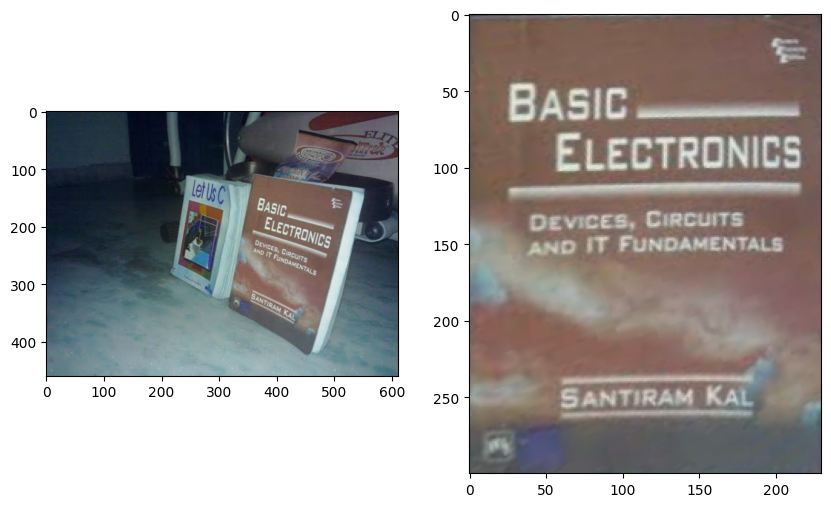

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('right.jpg')
rows,cols,chans = img.shape

startpts =  np.float32([[362, 107], [530,139] , [453,416], [319,337]])
endpts   =  np.float32([[100, 100], [330,100],  [330,400], [100,400]])

M = cv2.getPerspectiveTransform(startpts,endpts)

dst = cv2.warpPerspective(img,M,(rows,cols))

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst[100:400,100:330])

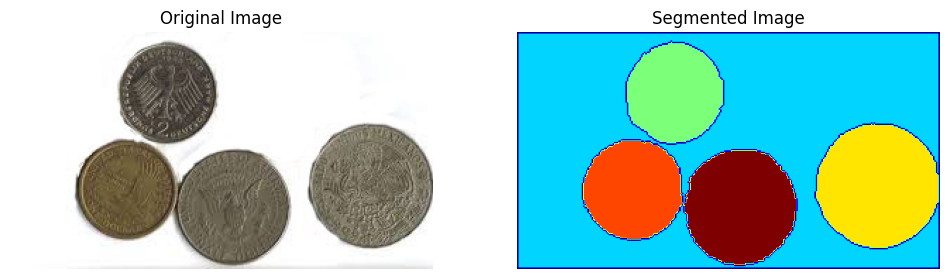

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('coinsb.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)

# Display the images using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(markers, cmap='jet')
plt.title('Segmented Image')
plt.axis('off')

plt.show()



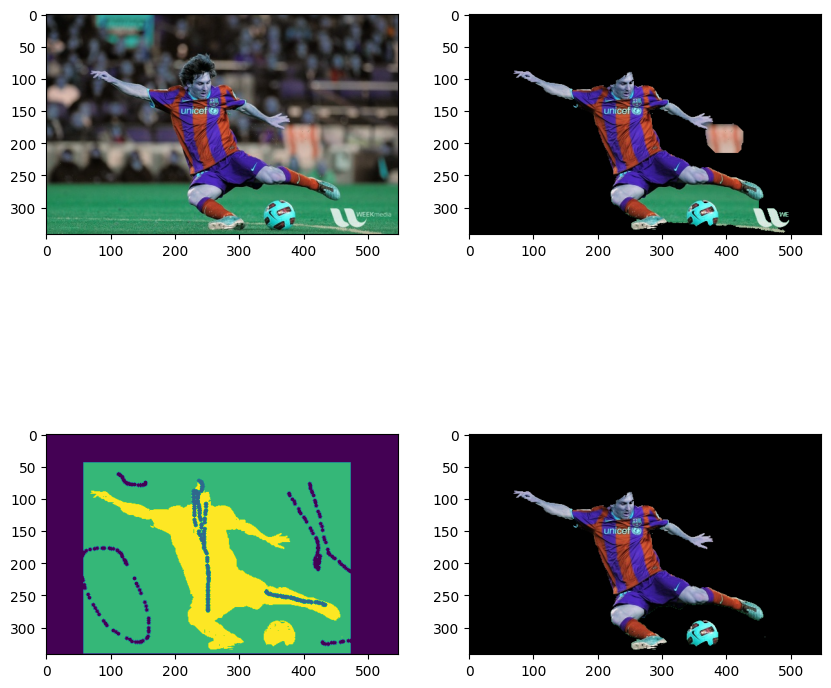

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('messi5.jpg')
orig = img.copy()
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

rect = (50, 50, 450, 290)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img = img * mask2[:, :, np.newaxis]
img_interm = img.copy()

newmask = cv2.imread('messimask.png', 0)

mask = newmask

mask, bgdModel, fgdModel = cv2.grabCut(img, mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img = img * mask[:, :, np.newaxis]

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(orig)
plt.subplot(2, 2, 2)
plt.imshow(img_interm)
plt.subplot(2, 2, 3)
plt.imshow(newmask)
plt.subplot(2, 2, 4)
plt.imshow(img)
plt.show()


(<AxesSubplot: title={'center': 'Output'}>,
 Text(0.5, 1.0, 'Output'))

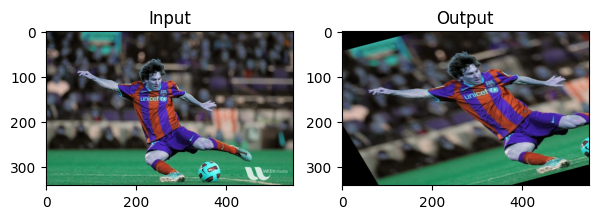

In [9]:
img = cv2.imread('messi5.jpg')
rows,cols,ch = img.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(cols,rows))

plt.figure(figsize=(7,7))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

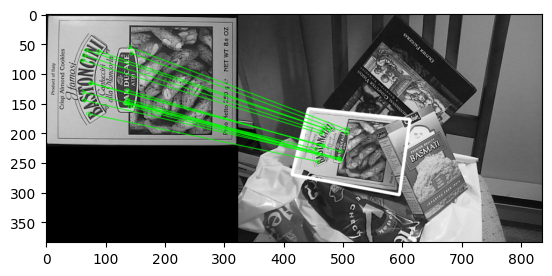

In [20]:
MIN_MATCH_COUNT = 10 #make sure we have at least 10 points to compare/match

img1 = cv2.imread('box.png',0)          # query image
img2 = cv2.imread('box_in_scene.png',0) # main image

# Initiate  detector

###uncomment one of these
# detector = cv2.xfeatures2d.SIFT_create(); norm = cv2.NORM_L2

# detector = cv2.xfeatures2d.SURF_create(800); norm = cv2.NORM_L2

detector = cv2.ORB_create(400); norm = cv2.NORM_HAMMING

# detector = cv2.AKAZE_create(); norm = cv2.NORM_HAMMING

# detector = cv2.BRISK_create(); norm = cv2.NORM_HAMMING


# find the keypoints and descriptors with chosen detector
kp1, des1 = detector.detectAndCompute(img1,None)
kp2, des2 = detector.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

#we've found the points, now we need to find matching pairs
matcher =  cv2.BFMatcher(norm) #BF = brute force
#Flann matcher can be more efficient but also more tempermental

#find the matches
matches = matcher.knnMatch(des1,trainDescriptors=des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None


draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure()
plt.imshow(img3, 'gray')

VEDIO

In [21]:
import cv2
from IPython.display import clear_output

def playvideo(vidname):
    vid = cv2.VideoCapture(vidname)

    try:
        while(True):
            ret, frame = vid.read()
            if not ret:
                vid.release()
                print("Released Video Resource")
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = ourprocessing(frame)
            plt.axis('off')
            plt.title("Input Stream")
            plt.imshow(frame)
            plt.show()
            clear_output(wait=True)
    except KeyboardInterrupt:
        vid.release()
        print("Released Video Resource")

#we'll override this to do some interesting stuff in a bit        
def ourprocessing(frame):
    return frame


playvideo('Megamind.avi')

Released Video Resource


In [24]:
def playvideowin(vidname,winname='video'):
    vid = cv2.VideoCapture(vidname)


    while(True):
        ret, frame = vid.read()
        if not ret:
            vid.release()
            print("Released Video Resource")
            break
        frame = ourprocessing(frame)
        
        cv2.namedWindow(winname)
        cv2.startWindowThread() #this normally isn't required
        cv2.imshow(winname,frame)
        k=cv2.waitKey(1)
        
        if k==27: #exit is Esc is pressed
            break

    cv2.destroyAllWindows()

        

def ourprocessing(frame):
    return frame


playvideowin('Megamind.avi')

Released Video Resource


In [25]:
def ourprocessing(frame):
    frame = cv2.GaussianBlur(frame,(29,29),0)
    return frame

playvideowin('Megamind.avi')

Released Video Resource


In [26]:
cap = cv2.VideoCapture('Megamind.avi')

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 30.0, (720,528)) #I hardcoded the resolution for simplicity;
                                                            #generally you should check it and set accordingly

while True:
    ret, frame = cap.read()
    
    if not ret:
        break
        
    frame = ourprocessing(frame)
    
    out.write(frame)
    
cap.release()
out.release()

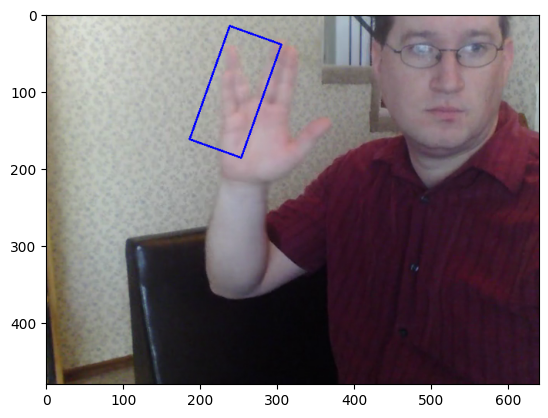

In [28]:
cap = cv2.VideoCapture('me.mp4')

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
# r,h,c,w = 250,90,400,125  # simply hardcoded the values
r,h,c,w = 30,150,155,80  # simply hardcoded the values

track_window = (c,r,w,h)

# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
cap.release()

plt.figure()

for index in range(3):
    
    cap = cv2.VideoCapture('me.mp4')

    while(1):
        ret ,frame = cap.read()

        if ret == True:
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

            # apply meanshift to get the new location
            ret, track_window = cv2.CamShift(dst, track_window, term_crit)

            # Draw it on image
            pts = cv2.boxPoints(ret)
            pts = np.int0(pts)
            img2 = cv2.polylines(frame,[pts],True, 255,2)
    #         cv2.imshow('img2',img2)
            plt.imshow(cv2.cvtColor(img2,4))
            plt.show()
            clear_output(wait=True)


        else:
            break

    cap.release()



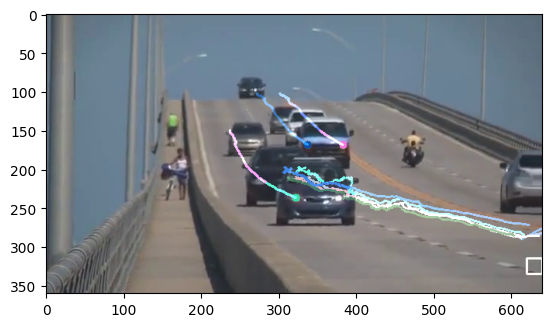

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

cap = cv2.VideoCapture('carsc.mp4')

# params for ShiTomasi corner detection
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# Take the first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

plt.figure()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

    img = cv2.add(frame, mask)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert back to BGR before displaying
    plt.show()
    clear_output(wait=True)

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)


ML

In [34]:
from IPython.display import YouTubeVideo
YouTubeVideo('e7OZccjx2MQ')

In [42]:
from multiprocessing.pool import ThreadPool
import cv2
import numpy as np
from numpy.linalg import norm

def mosaic(rows, images):
    images = list(images)
    n = len(images)
    rows = min(rows, n)
    height = sum(images[i].shape[0] for i in range(rows))
    width = (images[0].shape[1]) * ((n + rows - 1) // rows)
    mosaic_img = np.zeros((height, width, 3), dtype=np.uint8)

    for idx, image in enumerate(images):
        x = (idx % rows) * image.shape[1]
        y = (idx // rows) * image.shape[0]

        # Convert grayscale image to 3-channel BGR if needed
        if image.shape[-1] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        mosaic_img[y:y+image.shape[0], x:x+image.shape[1]] = image

    return mosaic_img




def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

class StatModel(object):
    def load(self, fn):
        self.model.load(fn)  # Known bug: https://github.com/opencv/opencv/issues/4969
    def save(self, fn):
        self.model.save(fn)
class SVM(StatModel):
    def __init__(self, C = 1, gamma = 0.5):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        return self.model.predict(samples)[1].ravel()


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    err = (labels != resp).mean()
    print('error: %.2f %%' % (err*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    print()

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        vis.append(img)
    return mosaic(25, vis)

def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        # transform to Hellinger kernel
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        samples.append(hist)
    return np.float32(samples)


SZ = 20 # size of each digit is SZ x SZ
CLASS_N = 10
DIGITS_FN = 'digits.png'


print('loading "%s" ...' % DIGITS_FN)
digits_img = cv2.imread(DIGITS_FN, 0)
digits = split2d(digits_img, (SZ, SZ))
labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)

print('preprocessing...')
# shuffle digits
rand = np.random.RandomState(321)
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]


digits2 = list(map(deskew, digits))
samples = preprocess_hog(digits2)

train_n = int(0.9*len(samples))
# cv2.imshow('test set', mosaic(25, digits[train_n:]))
digits_train, digits_test = np.split(digits2, [train_n])
samples_train, samples_test = np.split(samples, [train_n])
labels_train, labels_test = np.split(labels, [train_n])



print('training SVM...')
model = SVM(C=2.67, gamma=5.383)
model.train(samples_train, labels_train)
vis = cv2.cvtColor( evaluate_model(model, digits_test, samples_test, labels_test),cv2.COLOR_BGR2RGB)
# cv2.imshow('SVM test', vis)
print('saving SVM as "digits_svm.dat"...')
model.save('digits_svm.dat')

plt.figure(figsize=(20, 15))
plt.subplot(2,1,1)
plt.imshow(mosaic(25, digits[train_n:]),cmap='gray')
plt.subplot(2,1,2)
plt.imshow(vis)

loading "digits.png" ...
preprocessing...
training SVM...
error: 1.80 %
confusion matrix:
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  0  0]
 [ 0  0 59  2  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  1  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  1  0 50  0  0  0  0]
 [ 0  0  0  0  1  0 51  0  0  0]
 [ 0  0  1  0  0  0  0 54  0  0]
 [ 0  0  0  0  0  0  0  0 47  0]
 [ 0  1  0  1  0  0  0  0  1 45]]



ValueError: could not broadcast input array from shape (20,20,3) into shape (20,0,3)

IMAGE POSE DETECTOR

In [6]:
import cv2
from urllib import request
from numpy import fromstring, uint8
from matplotlib.pyplot import imshow, figure

# Load the pre-trained face and eye cascades
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

# Check if the cascade classifiers loaded successfully
if face_cascade.empty() or eye_cascade.empty():
    print('Error: Cascade classifiers not loaded.')
else:
    # Get the image from the web
    data = request.urlopen('https://casis.llnl.gov/content/assets/images/rever_small.jpg').read()
    # data = cv2.imread("./S2.jpg")
    data = fromstring(data, uint8)
    img_data = cv2.imdecode(data, -1)
    img = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)



# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Function to calculate the eye aspect ratio (EAR)
def eye_aspect_ratio(eye):
    A = ((eye[1][0] - eye[5][0]) ** 2 + (eye[1][1] - eye[5][1]) ** 2) ** 0.5
    B = ((eye[2][0] - eye[4][0]) ** 2 + (eye[2][1] - eye[4][1]) ** 2) ** 0.5
    C = ((eye[0][0] - eye[3][0]) ** 2 + (eye[0][1] - eye[3][1]) ** 2) ** 0.5
    ear = (A + B) / (2.0 * C)
    return ear

# Iterate over detected faces, find eyes, and draw rectangles around found objects
for (x, y, w, h) in faces:
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img[y:y + h, x:x + w]
    eyes = eye_cascade.detectMultiScale(roi_gray)

    # Calculate eye aspect ratio for each detected eye
    ear_values = []
    for (ex, ey, ew, eh) in eyes:
        eye = [(ex, ey), (ex + ew // 2, ey + eh // 2), (ex + ew, ey), (ex + ew // 2, ey + eh), (ex, ey + eh // 2), (ex + ew, ey + eh // 2)]
        ear = eye_aspect_ratio(eye)
        ear_values.append(ear)

        # Draw rectangles around eyes based on the EAR threshold
        threshold = 0.2
        if ear > threshold:
            cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

    # Check if the user is facing the camera based on EAR values
    if all(ear > threshold for ear in ear_values):
        cv2.putText(roi_color, 'Facing Camera', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(roi_color, 'Not Facing Camera', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

figure(figsize=(12, 11))
imshow(img)

C:\Users\97156\AppData\Local\Temp\ipykernel_6208\2728157059.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = fromstring(data, uint8)


<IPython.core.display.Javascript object>

In [14]:
import cv2
import numpy as np
from urllib import request
import matplotlib.pyplot as plt

# Load the pre-trained face, eye, and smile cascades
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('haarcascade_smile.xml')

# Check if the cascade classifiers loaded successfully
if face_cascade.empty() or eye_cascade.empty() or smile_cascade.empty():
    print('Error: Cascade classifiers not loaded.')
else:
    # Get the image from the web (replace the URL with the image URL you want to use)
    response = request.urlopen('https://casis.llnl.gov/content/assets/images/rever_small.jpg')
    data = response.read()
    img_data = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(img_data, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Function to calculate the eye aspect ratio (EAR)
    def eye_aspect_ratio(eye):
        # Your eye aspect ratio calculation here
        pass

    # Function to calculate the smile detection score
    def smile_detection_score(smile_roi):
        # Your smile detection score calculation here
        pass

    # Iterate over detected faces, find eyes and smiles, and draw rectangles around found objects
    for (x, y, w, h) in faces:
        # Draw rectangle around the face
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        
        # Detect eyes in the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)

        # Calculate eye aspect ratio for each detected eye
        ear_values = []
        for (ex, ey, ew, eh) in eyes:
            eye = [(ex, ey), (ex + ew // 2, ey + eh // 2), (ex + ew, ey), (ex + ew // 2, ey + eh), (ex, ey + eh // 2), (ex + ew, ey + eh // 2)]
            ear = eye_aspect_ratio(eye)
            if ear is not None:  # Check if the eye aspect ratio is calculated successfully
                ear_values.append(ear)

                # Draw rectangles around eyes based on the EAR threshold
                threshold = 0.2
                if ear > threshold:
                    cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        # Detect smiles in the face region
        smiles = smile_cascade.detectMultiScale(roi_gray)

        # Calculate smile detection score for each detected smile
        smile_values = []
        for (sx, sy, sw, sh) in smiles:
            smile_roi = roi_gray[sy:sy + sh, sx:sx + sw]
            smile_score = smile_detection_score(smile_roi)
            if smile_score is not None:  # Check if the smile detection score is calculated successfully
                smile_values.append(smile_score)

                # Draw rectangle around the smile region
                cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 2)

    # Calculate scores for each detection (replace these with your actual scoring logic)
    is_facing_camera_score = 1.0
    eyes_directed_camera_score = sum(ear_values) / len(ear_values) if ear_values else 0.0
    mouth_open_score = sum(smile_values) / len(smile_values) if smile_values else 0.0
    is_smiling_score = sum(smile_values) / len(smile_values) if smile_values else 0.0

    # Display the image with detections and scores
    cv2.imshow('Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


